# Task 1

First we get the S-protein nucleotide sequence from the NCBI ORFfinder tool which are roughly 3840 nucleotides long.

- For the Wuhan variant it is ORF26
- For the Omicron variant it is ORF26
- For the Hiroshima variant it is ORF18

These nucleotide sequences are downloaded first then restricted to nucleotides 1374 to 1449


The packages used in this notebook are:
- Bio
- pandas
- matplotlib
- numpy
- networkx
- copy

In [1]:
# Download the nucleotide sequences

from Bio import Entrez
Entrez.email = "Victor.Morland@warwick.ac.uk"

handle = Entrez.efetch(db="nucleotide", id="NC_045512.2", rettype="fasta", retmode="xml")
record = Entrez.read(handle, "fasta")
handle.close()
wuhanStrain = record[0]['TSeq_sequence']

handle = Entrez.efetch(db="nucleotide", id="OM095411.1", rettype="fasta", retmode="xml")
record = Entrez.read(handle, "fasta")
handle.close()
omicronStrain = record[0]['TSeq_sequence']

handle = Entrez.efetch(db="nucleotide", id="OL638173.1", rettype="fasta", retmode="xml")
record = Entrez.read(handle, "fasta")
handle.close()
hiroshimaStrain = record[0]['TSeq_sequence']

We get the S-proteins and restrict to the 1374 to 1449 nucleotides

Take the 1373 to 1449 slice of the string as in python we start at 0 but in the sequence we start at 1.
And the last element of the slice is not taken.

We do the same for the S-protein nucleotide sequence

In [2]:
wuhanStrain = wuhanStrain[21535:25384][1373:1449]
omicronStrain = omicronStrain[21487:25327][1373:1449]
hiroshimaStrain = hiroshimaStrain[21510:25353][1373:1449]

print("Wuhan:\n{}".format(wuhanStrain))
print(len(wuhanStrain))
print('\n////\n')
print("Omicron:\n{}".format(omicronStrain))
print(len(omicronStrain))
print('\n////\n')
print("Hiroshima:\n{}".format(hiroshimaStrain))
print(len(hiroshimaStrain))

Wuhan:
TAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAG
76

////

Omicron:
GTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAAC
76

////

Hiroshima:
CCGGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGT
76


## Create the dot plots

This is done using matplotlib scatter plots.
First we get the nucelotides where they are matching and describe where they match in the getYValues function.
Then using that we can plot.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def getYValues(s1,s2):
    y = []
    for i, nuc1 in enumerate(s1):
        subList = []
        for j,nuc2 in enumerate(s2):
            if nuc1 == nuc2:
                subList.append(j)
            else:
                #subList.append(-1)
                pass
        y.append(subList)
    return y



def buildDotPlot(s1, s2, xAxis, yAxis):
    plt.figure(figsize=(25, 25))
    y = getYValues(s1,s2)
    x = range(len(s1))
    for xe, ye in zip(x, y):
        plt.scatter([xe] * len(ye), ye)


    plt.xticks(x, s1, rotation='horizontal')
    plt.yticks(x, s2, rotation='horizontal')
    plt.xlabel(xAxis)
    plt.ylabel(yAxis)
    plt.title('{} - {}'.format(xAxis, yAxis))
    plt.show()

    
#strain1 = 'ATTCGCCAT'
#strain2 = 'GTACCCTTC'
#buildDotPlot(strain1, strain2, 'Strain1', 'Strain2')

### Dot plot of the Wuhan-Omicron Combination

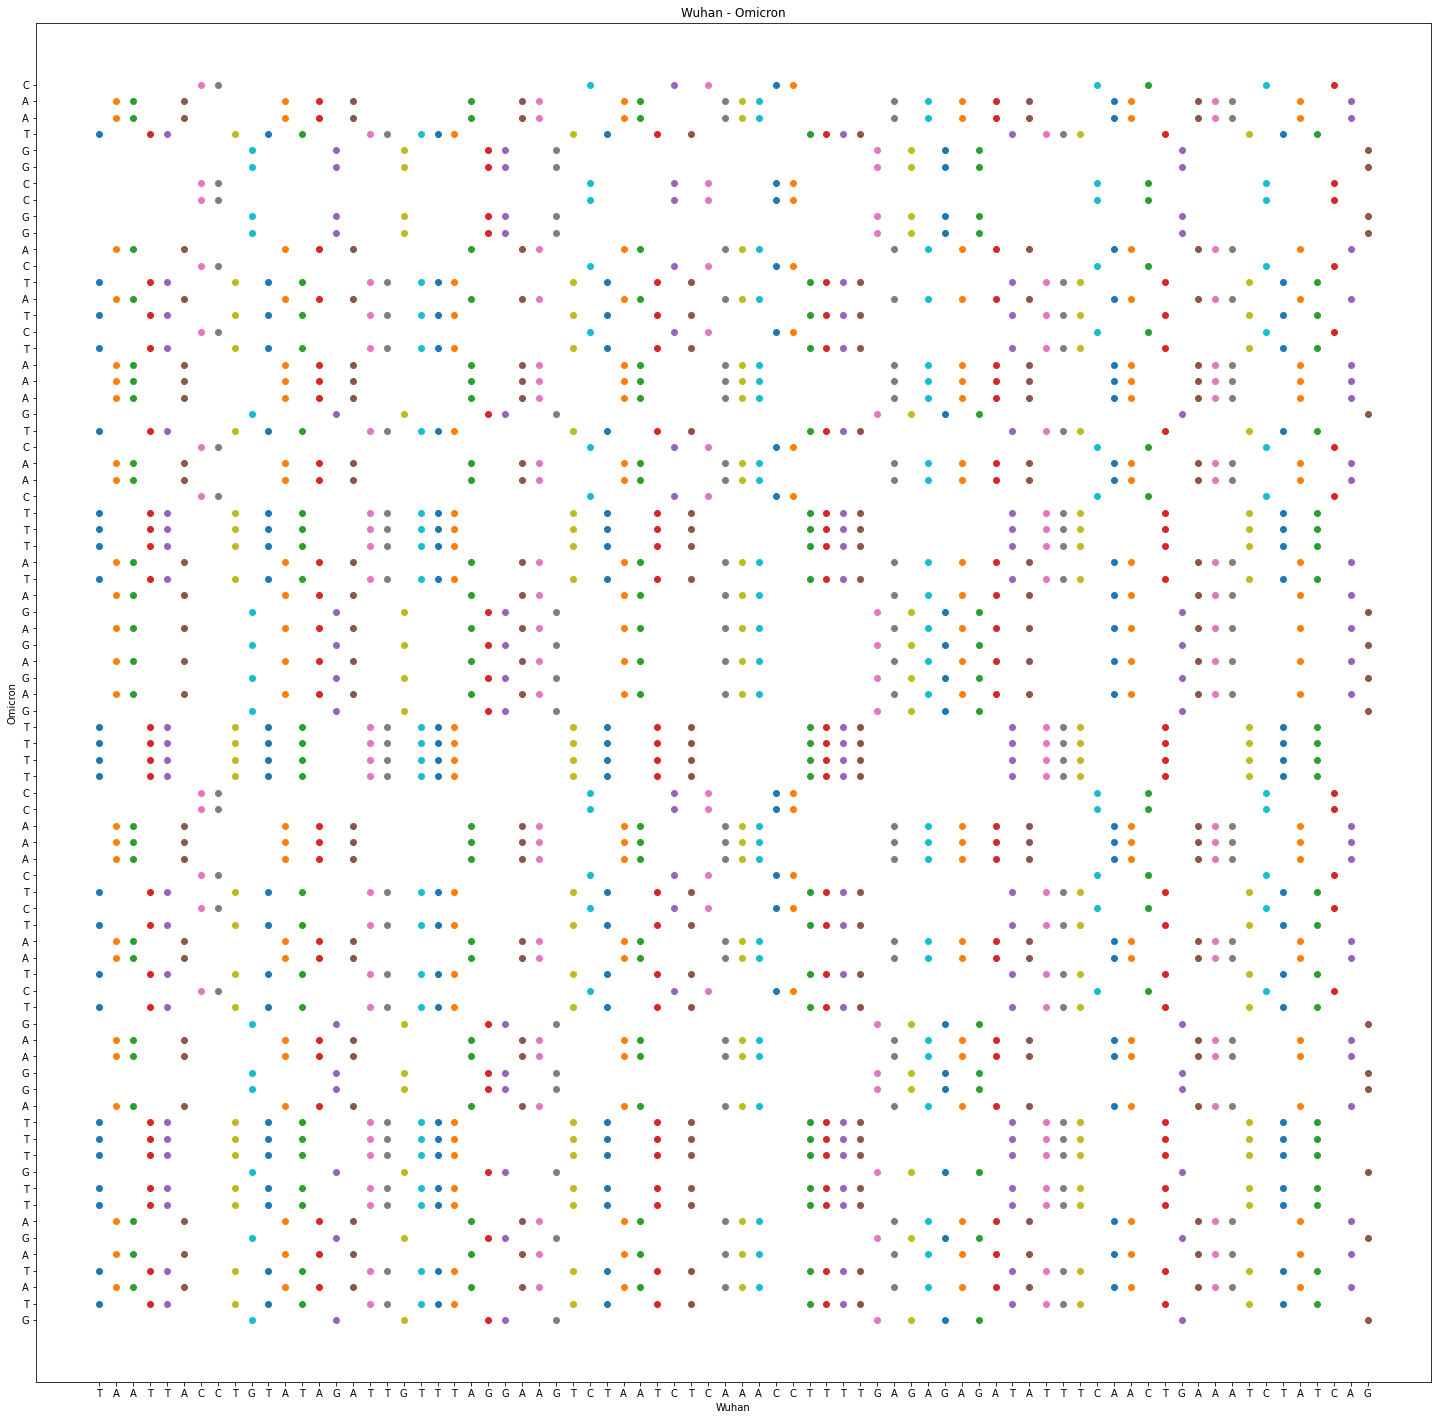

In [4]:
buildDotPlot(wuhanStrain, omicronStrain, 'Wuhan', 'Omicron')

### Dot plot of the Wuhan-Hiroshima Combination

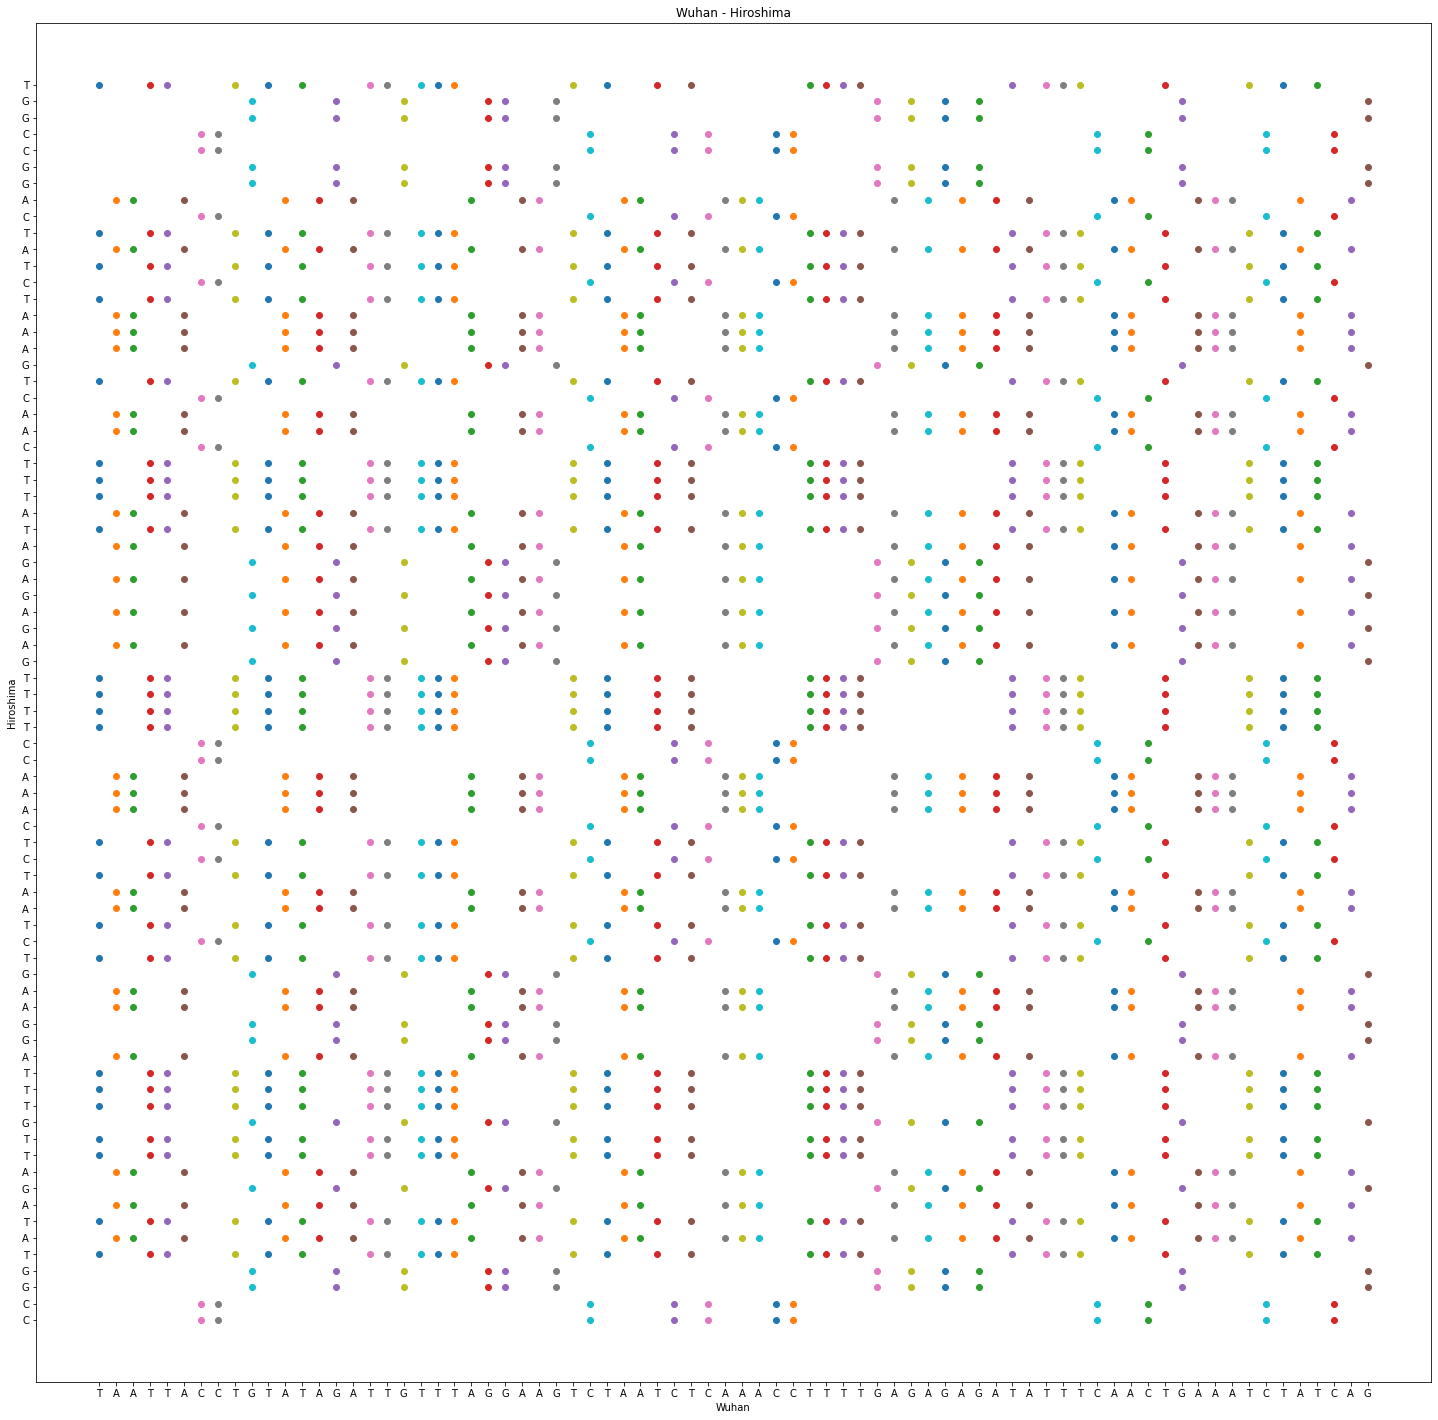

In [5]:
buildDotPlot(wuhanStrain, hiroshimaStrain, 'Wuhan', 'Hiroshima')

### Dot plot of the Hiroshima-Omicron Combination

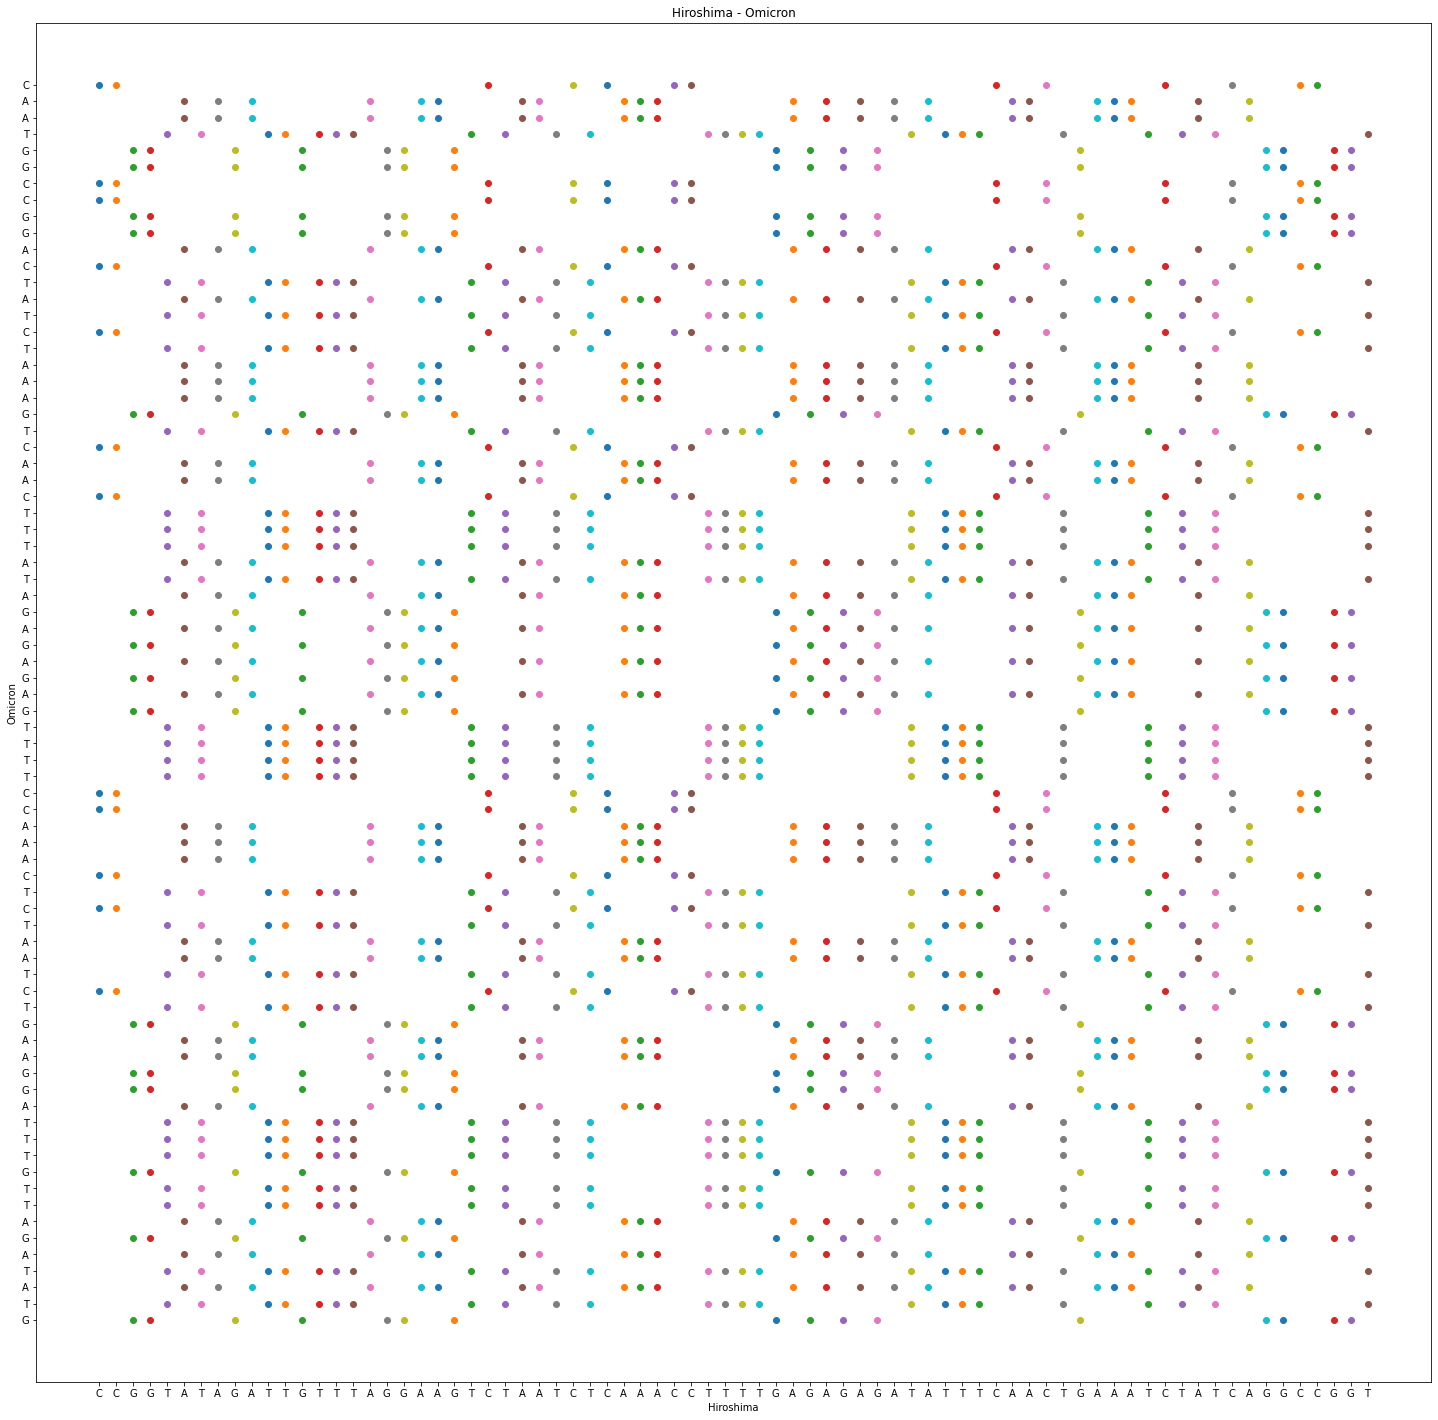

In [6]:
buildDotPlot(hiroshimaStrain, omicronStrain, 'Hiroshima', 'Omicron')

## Compute Needleman-Wunsch Scores for pairwise alignment

- First we create the algorithm to compute the F matrix to find the alignment scores between two sequences.
- Then we create the algorithm to get the best alignment (only returns one alignment if there are multiple best alignments) between two sequences that corresponds the the alignment score.

In [7]:
import numpy as np

def computeF(A,B,S,d=-1,lToA={'A': 0, 'C': 1, 'G': 2, 'T': 3}):
    """
    Computes the alignment for two given sequences using the NWA matrix
    
    Parameters
    ----------
    
    A: str 
        is a list of sequences that have already been aligned with eachother (includes '-')
    B: str 
        is a list of sequences that have already been aligned with eachother (includes '-')
    S: (4x4) 2D np array 
        Scoring matrix
    d: int
        penalty for matching with '-'
    lToA: char -> [0-3] dictionary
        dictionary which assigns a number to the letters in DNA for identification
        
    Return
    ------
    
    Returns the NWA matrix as a 2D numpy array of the input sequences
    """
        
    F = np.zeros((len(A)+1,len(B)+1))
    for i in range(len(A)+1):
        F[i][0] = d * i

    for i in range(len(B)+1):
        F[0][i] = d * i

    for i in range(1,len(A)+1):
        for j in range(1,len(B)+1):
            match = F[i-1][j-1] + S[lToA[A[i-1]]][lToA[B[j-1]]]
            delete = F[i-1][j] + d
            insert = F[i][j-1] + d
            F[i][j] = max(match, delete, insert)
    
    return F

In [8]:
def findAlignment(A,B,F,S,d=-1,lToA={'A': 0, 'C': 1, 'G': 2, 'T': 3}):
    """
    Computes the alignment for two given sequences using the NWA matrix
    
    Parameters
    ----------
    
    A: str list
        is a list of sequences that have already been aligned with eachother (includes '-')
    B: str 
        is a list of sequences that have already been aligned with eachother (includes '-')
    F: (len(A) x len(B)) 2D numpy array
        NWA matrix
    S: (4x4) 2D np array 
        Scoring matrix
    d: int
        penalty for matching with '-'
    lToA: char -> [0-3] dictionary
        dictionary which assigns a number to the letters in DNA for identification
        
    Return
    ------
    
    Returns a tuple of an optimal alignment of the two input sequences
    """
    
    alignmentA = ''
    alignmentB = ''
    i = len(A)
    j = len(B)

    while i > 0 or j > 0:
        if i > 0 and j > 0 and F[i][j] == F[i-1][j-1] + S[lToA[A[i-1]]][lToA[B[j-1]]]:
            alignmentA = A[i-1] + alignmentA
            alignmentB = B[j-1] + alignmentB
            i = i - 1
            j = j - 1
        elif i > 0 and F[i][j] == F[i-1][j] + d:
            alignmentA = A[i-1] + alignmentA
            alignmentB = '-' + alignmentB
            i = i - 1
        else:
            alignmentA = '-' + alignmentA
            alignmentB = B[j-1] + alignmentB
            j = j -1
    
    return alignmentA, alignmentB

### Gets the pairwise alignment scores for the three sequences and displays them in a table

In [9]:
df_scores = pd.DataFrame({'Match': [], 'Score': []})
# Scoring Matrix
S = np.array([[1,-1,-1,-1],[-1,1,-1,-1],[-1,-1,1,-1],[-1,-1,-1,1]])
# Gap Penalty
d = -1
# Letter -> Array Map
lToA = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

# Wuhan - Omicron
F1 = computeF(wuhanStrain,omicronStrain,S,d,lToA)
score1 = F1[len(wuhanStrain)][len(omicronStrain)]

# Wuhan - Hiroshima
F2 = computeF(wuhanStrain,hiroshimaStrain,S,d,lToA)
score2 = F2[len(wuhanStrain)][len(hiroshimaStrain)]

# Hiroshima - Omicron
F3 = computeF(hiroshimaStrain,omicronStrain,S,d,lToA)
score3 = F3[len(hiroshimaStrain)][len(omicronStrain)]

df_scores.loc[len(df_scores.index)] = ['Wuhan - Omicron', score1]
df_scores.loc[len(df_scores.index)] = ['Wuhan - Hiroshima', score2]
df_scores.loc[len(df_scores.index)] = ['Hiroshima - Omicron', score3]

print(df_scores.to_string(index=False))

print('\nWuhan-Omicron:')
print(F1)
print('\nWuhan-Hiroshima:')
print(F2)
print('\nHiroshima-Omicron:')
print(F3)

              Match  Score
    Wuhan - Omicron   49.0
  Wuhan - Hiroshima   56.0
Hiroshima - Omicron   67.0

Wuhan-Omicron:
[[  0.  -1.  -2. ... -74. -75. -76.]
 [ -1.  -1.   0. ... -72. -73. -74.]
 [ -2.  -2.  -1. ... -70. -71. -72.]
 ...
 [-74. -72. -70. ...  47.  46.  45.]
 [-75. -73. -71. ...  49.  48.  47.]
 [-76. -74. -72. ...  51.  50.  49.]]

Wuhan-Hiroshima:
[[  0.  -1.  -2. ... -74. -75. -76.]
 [ -1.  -1.  -2. ... -72. -73. -74.]
 [ -2.  -2.  -2. ... -70. -71. -72.]
 ...
 [-74. -72. -70. ...  54.  53.  52.]
 [-75. -73. -71. ...  56.  55.  54.]
 [-76. -74. -72. ...  58.  57.  56.]]

Hiroshima-Omicron:
[[  0.  -1.  -2. ... -74. -75. -76.]
 [ -1.  -1.  -2. ... -72. -73. -74.]
 [ -2.  -2.  -2. ... -70. -71. -72.]
 ...
 [-74. -72. -70. ...  65.  64.  63.]
 [-75. -73. -71. ...  67.  66.  65.]
 [-76. -74. -72. ...  69.  68.  67.]]


### Pairwise Alignment of the sequences

In [10]:
hiroshima_omicron_align = findAlignment(hiroshimaStrain,omicronStrain,F3,S,d,lToA)
wuhan_hiroshima_align = findAlignment(wuhanStrain,hiroshimaStrain,F2,S,d,lToA)
wuhan_omicron_align = findAlignment(wuhanStrain,omicronStrain,F1,S,d,lToA)

print('Alignment Hiroshima with Omicron: \n{}\n{}'.format(hiroshima_omicron_align[0], hiroshima_omicron_align[1]))
print('\n')
print('Alignment Wuhan with Hiroshima: \n{}\n{}'.format(wuhan_hiroshima_align[0], wuhan_hiroshima_align[1]))
print('\n')
print('Alignment Wuhan with Omicron: \n{}\n{}'.format(wuhan_omicron_align[0], wuhan_omicron_align[1]))

Alignment Hiroshima with Omicron: 
CCGGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGT---
---GTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAAC


Alignment Wuhan with Hiroshima: 
TAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCA-----G-
------CCGGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGT


Alignment Wuhan with Omicron: 
TAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCA-----G----
---------GTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAAC


## Extend NWA to compute alignment of alignments

In [11]:
def computeF_Ext(A_lst,B_lst,S,lToA={'-': 0, 'A': 1, 'C': 2, 'G': 3, 'T': 4}):
    """
    Computes the NWA matrix for two given alignments
    
    Parameters
    ----------
    
    A_lst: str list
        is a list of sequences that have already been aligned with eachother (includes '-')
    B_lst: str list
        is a list of sequences that have already been aligned with eachother (includes '-')
    S: (5x5) 2D np array 
        Scoring matrix
    lToA: char -> [0-4] dictionary
        dictionary which assigns a number to the letters in DNA for identification
    
    Return
    ------
    
    Returns the NWA matrix as a 2D numpy array of the input alignments
    """
    
    # Add '-' to start of sequences
    for i, align in enumerate(A_lst):
        A_lst[i] = '-' + align
    
    for i, align in enumerate(B_lst):
        B_lst[i] = '-' + align
    
    alignALen = len(A_lst[0])
    alignBLen = len(B_lst[0])
    
    # Start defining F matrix
    F = np.zeros((alignALen,alignBLen))
    
    for i in range(1,alignALen):
        temp = 0       
        for alignA in A_lst:
            for alignB in B_lst:
                
                temp += S[lToA[alignA[i]]][lToA['-']]
        F[i][0] = temp + F[i-1][0]

    for i in range(1,alignBLen):
        temp = 0
        for alignB in B_lst:
            for alignA in A_lst:
                                       
                temp += S[lToA[alignB[i]]][lToA['-']]
        F[0][i] = temp + F[0][i-1]

    
    for i in range(1, alignALen):
        for j in range(1, alignBLen):
            temp1 = 0
            temp2 = 0
            temp3 = 0
            for alignA in A_lst:
                for alignB in B_lst:
                    temp1 += S[lToA[alignA[i]]][lToA[alignB[j]]]
                    temp2 += S[lToA[alignA[i]]][lToA['-']]
                    temp3 += S[lToA[alignB[j]]][lToA['-']]

            match = F[i-1][j-1] + temp1
            delete = F[i-1][j] + temp2
            insert = F[i][j-1] + temp3
            F[i][j] = max(match, delete, insert)
    
    # Removing '-' from start of sequences
    for i, align in enumerate(A_lst):
        A_lst[i] = align[1:]
    
    # Removing '-' from start of sequences
    for i, align in enumerate(B_lst):
        B_lst[i] = align[1:]
            
    return F

In [12]:
def findAlignment_Ext(A_lst,B_lst,F,S,lToA={'A': 0, 'C': 1, 'G': 2, 'T': 3}):
    """
    Computes the alignment for two given alignments using the NWA matrix
    
    Parameters
    ----------
    
    A_lst: str list
        is a list of sequences that have already been aligned with eachother (includes '-')
    B_lst:  str list
        is a list of sequences that have already been aligned with eachother (includes '-')
    F: (len(A_lst[0]) x len(B_lst[0])) 2D numpy array
        NWA matrix
    S: (5x5) 2D np array 
        Scoring matrix
    lToA: char -> [0-4] dictionary
        dictionary which assigns a number to the letters in DNA for identification
        
    Return
    ------
    
    Returns a tuple of an optimal alignment of the two input alignments
    """
    
    alignmentA = ['' for align in A_lst]
    alignmentB = ['' for align in B_lst]
    
    i = len(A_lst[0])
    j = len(B_lst[0])

    while i > 0 or j > 0:
        temp1 = 0
        temp2 = 0
        #temp3 = 0
        
        for alignA in A_lst:
            for alignB in B_lst:
                temp1 += S[lToA[alignA[i-1]]][lToA[alignB[j-1]]]
                temp2 += S[lToA[alignA[i-1]]][lToA['-']]
                #temp3 += S[lToA[alignB[j]]][lToA['-']]
                
        if i > 0 and j > 0 and F[i][j] == F[i-1][j-1] + temp1:
            for k, alignA in enumerate(A_lst):
                alignmentA[k] = alignA[i-1] + alignmentA[k]
            for k, alignB in enumerate(B_lst):
                alignmentB[k] = alignB[j-1] + alignmentB[k]
            i = i - 1
            j = j - 1
        elif i > 0 and F[i][j] == F[i-1][j] + temp2:
            for k, alignA in enumerate(A_lst):
                alignmentA[k] = alignA[i-1] + alignmentA[k]
            for k, alignB in enumerate(B_lst):
                alignmentB[k] = '-' + alignmentB[k]
            i = i - 1
        else:
            for k, alignA in enumerate(A_lst):
                alignmentA[k] = '-' + alignmentA[k]
            for k, alignB in enumerate(B_lst):
                alignmentB[k] = alignB[j-1] + alignmentB[k]
            j = j - 1

    return alignmentA, alignmentB

### Gets the alignment of alignments scores for the three alignments and displays them in a table

In [13]:
df = pd.DataFrame({'Match': [], 'Score': []})
# Scoring Matrix
S = np.array([[0,-1,-1,-1,-1],[-1,1,-1,-1,-1],[-1,-1,1,-1,-1],[-1,-1,-1,1,-1],[-1,-1,-1,-1,1]])
# Letter -> Array Map
lToA = {'-': 0, 'A': 1, 'C': 2, 'G': 3, 'T': 4}

#A_lst = ['CCA']
#B_lst = ['TATG-','ATGGG']

#A_lst = ['GCATGCG']
#B_lst = ['GATTACA']

#A_lst = [hiroshimaStrain]
#B_lst = [omicronStrain]

A_lst_4 = [wuhanStrain]
B_lst_4 = [hiroshima_omicron_align[0], hiroshima_omicron_align[1]]

A_lst_5 = [omicronStrain]
B_lst_5 = [wuhan_hiroshima_align[0], wuhan_hiroshima_align[1]]

A_lst_6 = [hiroshimaStrain]
B_lst_6 = [wuhan_omicron_align[0], wuhan_omicron_align[1]]


F4 = computeF_Ext(A_lst_4, B_lst_4,S,lToA)
score4 = F4[F4.shape[0]-1][F4.shape[1]-1]
alignmentOfAlignments4 = findAlignment_Ext(A_lst_4, B_lst_4, F4, S, lToA)

F5 = computeF_Ext(A_lst_5, B_lst_5,S,lToA)
score5 = F5[F5.shape[0]-1][F5.shape[1]-1]
alignmentOfAlignments5 = findAlignment_Ext(A_lst_5, B_lst_5, F5, S, lToA)

F6 = computeF_Ext(A_lst_6, B_lst_6,S,lToA)
score6 = F6[F6.shape[0]-1][F6.shape[1]-1]
alignmentOfAlignments6 = findAlignment_Ext(A_lst_6, B_lst_6, F6, S, lToA)


df.loc[len(df.index)] = ['Wuhan - Hiroshima/Omicron', score4]
df.loc[len(df.index)] = ['Omicron - Wuhan/Hiroshima', score5]
df.loc[len(df.index)] = ['Hiroshima - Wuhan/Omicron', score6]

print(df.to_string(index=False))

print('\nWuhan - Hiroshima/Omicron:')
print(F4)
print('\nOmicron - Wuhan/Hiroshima:')
print(F5)
print('\nHiroshima - Wuhan/Omicron:')
print(F6)

                    Match  Score
Wuhan - Hiroshima/Omicron  105.0
Omicron - Wuhan/Hiroshima  116.0
Hiroshima - Wuhan/Omicron  123.0

Wuhan - Hiroshima/Omicron:
[[   0.   -1.   -2. ... -150. -151. -152.]
 [  -2.   -2.   -3. ... -146. -147. -148.]
 [  -4.   -4.   -4. ... -142. -143. -144.]
 ...
 [-148. -146. -144. ...   99.   98.   97.]
 [-150. -148. -146. ...  103.  102.  101.]
 [-152. -150. -148. ...  107.  106.  105.]]

Omicron - Wuhan/Hiroshima:
[[   0.   -1.   -2. ... -149. -151. -152.]
 [  -2.   -2.   -3. ... -145. -147. -148.]
 [  -4.   -2.   -3. ... -141. -143. -144.]
 ...
 [-148. -146. -144. ...  114.  118.  120.]
 [-150. -148. -146. ...  112.  116.  118.]
 [-152. -150. -148. ...  110.  114.  116.]]

Hiroshima - Wuhan/Omicron:
[[   0.   -1.   -2. ... -150. -151. -152.]
 [  -2.   -2.   -3. ... -146. -147. -148.]
 [  -4.   -4.   -4. ... -142. -143. -144.]
 ...
 [-148. -146. -144. ...  123.  122.  121.]
 [-150. -148. -146. ...  124.  123.  122.]
 [-152. -150. -148. ...  125.  124. 

### Alignment of Alignments

In [14]:
alignmentOfAlignments4 = findAlignment_Ext(A_lst_4, B_lst_4, F4, S, lToA)
alignmentOfAlignments5 = findAlignment_Ext(A_lst_5, B_lst_5, F5, S, lToA)
alignmentOfAlignments6 = findAlignment_Ext(A_lst_6, B_lst_6, F6, S, lToA)

print('Alignment Wuhan - Hiroshima/Omicron: \n{}\n{}\n{}'.format(alignmentOfAlignments4[0][0], 
                                                                 alignmentOfAlignments4[1][0], 
                                                                 alignmentOfAlignments4[1][1]))
print('\n')
print('Alignment Omicron - Wuhan/Hiroshima: \n{}\n{}\n{}'.format(alignmentOfAlignments5[0][0], 
                                                                 alignmentOfAlignments5[1][0], 
                                                                 alignmentOfAlignments5[1][1]))
print('')
print('Alignment Hiroshima - Wuhan/Omicron: \n{}\n{}\n{}'.format(alignmentOfAlignments6[0][0], 
                                                                 alignmentOfAlignments6[1][0], 
                                                                 alignmentOfAlignments6[1][1]))

Alignment Wuhan - Hiroshima/Omicron: 
TAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCA-----G----
------CCGGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGT---
---------GTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAAC


Alignment Omicron - Wuhan/Hiroshima: 
---------GTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAAC
TAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCA-----G----
------CCGGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGT---

Alignment Hiroshima - Wuhan/Omicron: 
------CCGGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGT---
TAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCA-----G----
---------GTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAAC


# Task 2

- Must first compute the NWA matrix
- Then we must get the alignment scores and lengths for each pair of sequences
- We then use these scores create the distance matrix
- Then build the tree combining the two closest seqeunces first recursively (using NJM)

In [15]:
handle = Entrez.efetch(db="nucleotide", id="NM_001030.6", rettype="fasta", retmode="xml")
record = Entrez.read(handle, "fasta")
handle.close()
human = record[0]['TSeq_sequence']

handle = Entrez.efetch(db="nucleotide", id="NM_027015.4", rettype="fasta", retmode="xml")
record = Entrez.read(handle, "fasta")
handle.close()
mouse = record[0]['TSeq_sequence']

handle = Entrez.efetch(db="nucleotide", id="NM_001251997.1", rettype="fasta", retmode="xml")
record = Entrez.read(handle, "fasta")
handle.close()
chimpanzee = record[0]['TSeq_sequence']

handle = Entrez.efetch(db="nucleotide", id="XM_026928592.1", rettype="fasta", retmode="xml")
record = Entrez.read(handle, "fasta")
handle.close()
catfish = record[0]['TSeq_sequence']

handle = Entrez.efetch(db="nucleotide", id="XM_006030956.2", rettype="fasta", retmode="xml")
record = Entrez.read(handle, "fasta")
handle.close()
alligator = record[0]['TSeq_sequence']

print("Human: \n{}".format(human))
print("\nMouse: \n{}".format(mouse))
print("\nChimpanzee: \n{}".format(chimpanzee))
print("\nCatfish: \n{}".format(catfish))
print("\nAlligator: \n{}".format(alligator))

Human: 
CCTTTCCGGCGGTGACGACCTACGCACACGAGAACATGCCTCTCGCAAAGGATCTCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGAAACACAAGAAGAAACGCCTGGTGCAGAGCCCCAATTCCTACTTCATGGATGTGAAATGCCCAGGATGCTATAAAATCACCACGGTCTTTAGCCATGCACAAACGGTAGTTTTGTGTGTTGGCTGCTCCACTGTCCTCTGCCAGCCTACAGGAGGAAAAGCAAGGCTTACAGAAGGATGTTCCTTCAGGAGGAAGCAGCACTAAAAGCACTCTGAGTCAAGATGAGTGGGAAACCATCTCAATAAACACATTTTGGATAAATCCTG

Mouse: 
CCTTTCCGGCGGTGACGACCTCCCTACGAGAACATGCCTCTCGCAAAGGATCTCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGAAACACAAGAAAAAGCGCCTGGTGCAGAGCCCCAATTCCTACTTTATGGACGTGAAATGCCCAGGATGCTATAAAATCACCACGGTCTTTAGCCATGCACAAACGGTAGTCTTGTGTGTTGGCTGCTCCACTGTCCTCTGTCAGCCTACAGGTGGAAAAGCAAGGCTGACAGAAGGATGCTCCTTCAGGAGGAAGCAGCACTGAAAGCCCCTGATTGAAGATGAGTGGGAACCTTCCCAATAAACACGTTTTGGATATATAAAAAAAAAAAAAAAAAAAAAAAAAA

Chimpanzee: 
CTTTCCGGCGGTGACGACCTACGCACCCGAGAACATGCCTCTCGCAAAGGATCTCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGAAACACAAGAAGAAACGCCTGGTGCAGAGCCCCAATTCCTACTTCATGGATGTGAAATGCCCAGGATGCTATAAAATCACCACGGTCTTTAGCCATGCACAAACGGTAGTTTTGTGTGTTGGCTGCTCCACTGTCCTCTGCCAGCCTACAGGAGGAAAAG

## Get the NWA Matrices for all pairwise combinations to get pairwise alignment scores

In [16]:
# Scoring Matrix
S = np.array([[1,-1,-1,-1],[-1,1,-1,-1],[-1,-1,1,-1],[-1,-1,-1,1]])
# Gap Penalty
d = -1
# Letter -> Array Map
lToA = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

F_human_mouse = computeF(human,mouse,S,d,lToA)
F_human_chimpanzee = computeF(human,chimpanzee,S,d,lToA)
F_human_catfish = computeF(human,catfish,S,d,lToA)
F_human_alligator = computeF(human,alligator,S,d,lToA)


F_mouse_chimpanzee = computeF(mouse,chimpanzee,S,d,lToA)
F_mouse_catfish = computeF(mouse,catfish,S,d,lToA)
F_mouse_alligator = computeF(mouse,alligator,S,d,lToA)


F_chimpanzee_catfish = computeF(chimpanzee,catfish,S,d,lToA)
F_chimpanzee_alligator = computeF(chimpanzee,alligator,S,d,lToA)


F_catfish_alligator = computeF(catfish,alligator,S,d,lToA)

### Create Alignment Score Matrix

In [17]:
Scores_Matrix = np.zeros((5,5))

# Human Alignment Scores
Scores_Matrix[0][1] = F_human_mouse[F_human_mouse.shape[0]-1][F_human_mouse.shape[1]-1]
Scores_Matrix[1][0] = F_human_mouse[F_human_mouse.shape[0]-1][F_human_mouse.shape[1]-1]

Scores_Matrix[0][2] = F_human_chimpanzee[F_human_chimpanzee.shape[0]-1][F_human_chimpanzee.shape[1]-1]
Scores_Matrix[2][0] = F_human_chimpanzee[F_human_chimpanzee.shape[0]-1][F_human_chimpanzee.shape[1]-1]

Scores_Matrix[0][3] = F_human_catfish[F_human_catfish.shape[0]-1][F_human_catfish.shape[1]-1]
Scores_Matrix[3][0] = F_human_catfish[F_human_catfish.shape[0]-1][F_human_catfish.shape[1]-1]

Scores_Matrix[0][4] = F_human_alligator[F_human_alligator.shape[0]-1][F_human_alligator.shape[1]-1]
Scores_Matrix[4][0] = F_human_alligator[F_human_alligator.shape[0]-1][F_human_alligator.shape[1]-1]


# Mouse Alignment Scores
Scores_Matrix[1][2] = F_mouse_chimpanzee[F_mouse_chimpanzee.shape[0]-1][F_mouse_chimpanzee.shape[1]-1]
Scores_Matrix[2][1] = F_mouse_chimpanzee[F_mouse_chimpanzee.shape[0]-1][F_mouse_chimpanzee.shape[1]-1]

Scores_Matrix[1][3] = F_mouse_catfish[F_mouse_catfish.shape[0]-1][F_mouse_catfish.shape[1]-1]
Scores_Matrix[3][1] = F_mouse_catfish[F_mouse_catfish.shape[0]-1][F_mouse_catfish.shape[1]-1]

Scores_Matrix[1][4] = F_mouse_alligator[F_mouse_alligator.shape[0]-1][F_mouse_alligator.shape[1]-1]
Scores_Matrix[4][1] = F_mouse_alligator[F_mouse_alligator.shape[0]-1][F_mouse_alligator.shape[1]-1]


# Chimpanzee Alignment Scores
Scores_Matrix[2][3] = F_chimpanzee_catfish[F_chimpanzee_catfish.shape[0]-1][F_chimpanzee_catfish.shape[1]-1]
Scores_Matrix[3][2] = F_chimpanzee_catfish[F_chimpanzee_catfish.shape[0]-1][F_chimpanzee_catfish.shape[1]-1]

Scores_Matrix[2][4] = F_chimpanzee_alligator[F_chimpanzee_alligator.shape[0]-1][F_chimpanzee_alligator.shape[1]-1]
Scores_Matrix[4][2] = F_chimpanzee_alligator[F_chimpanzee_alligator.shape[0]-1][F_chimpanzee_alligator.shape[1]-1]


# Catfish Alignment Scores
Scores_Matrix[3][4] = F_catfish_alligator[F_catfish_alligator.shape[0]-1][F_catfish_alligator.shape[1]-1]
Scores_Matrix[4][3] = F_catfish_alligator[F_catfish_alligator.shape[0]-1][F_catfish_alligator.shape[1]-1]

print("Alignment Scores Matrix")
print(Scores_Matrix)

Alignment Scores Matrix
[[  0. 278. 327.  53.  33.]
 [278.   0. 306.  75.  48.]
 [327. 306.   0.  73.  54.]
 [ 53.  75.  73.   0. 225.]
 [ 33.  48.  54. 225.   0.]]


## Get Alignments for pairwise combinations of sequences

In [18]:
human_mouse_align = findAlignment(human,mouse,F_human_mouse,S,d,lToA)
human_chimpanzee_align = findAlignment(human,chimpanzee,F_human_chimpanzee,S,d,lToA)
human_catfish_align = findAlignment(human,catfish,F_human_catfish,S,d,lToA)
human_alligator_align = findAlignment(human,alligator,F_human_alligator,S,d,lToA)

mouse_chimpanzee_align = findAlignment(mouse,chimpanzee,F_mouse_chimpanzee,S,d,lToA)
mouse_catfish_align = findAlignment(mouse,catfish,F_mouse_catfish,S,d,lToA)
mouse_alligator_align = findAlignment(mouse,alligator,F_mouse_alligator,S,d,lToA)

chimpanzee_catfish_align = findAlignment(chimpanzee,catfish,F_chimpanzee_catfish,S,d,lToA)
chimpanzee_alligator_align = findAlignment(chimpanzee,alligator,F_chimpanzee_alligator,S,d,lToA)

catfish_alligator_align = findAlignment(catfish,alligator,F_catfish_alligator,S,d,lToA)

### Create Alignment Length Matrix

In [19]:
Length_Matrix = np.zeros((5,5))

# Human Alignment Scores
Length_Matrix[0][1] = len(human_mouse_align[0])
Length_Matrix[1][0] = len(human_mouse_align[0])

Length_Matrix[0][2] = len(human_chimpanzee_align[0])
Length_Matrix[2][0] = len(human_chimpanzee_align[0])

Length_Matrix[0][3] = len(human_catfish_align[0])
Length_Matrix[3][0] = len(human_catfish_align[0])

Length_Matrix[0][4] = len(human_alligator_align[0])
Length_Matrix[4][0] = len(human_alligator_align[0])


# Mouse Alignment Scores
Length_Matrix[1][2] = len(mouse_chimpanzee_align[0])
Length_Matrix[2][1] = len(mouse_chimpanzee_align[0])

Length_Matrix[1][3] = len(mouse_catfish_align[0])
Length_Matrix[3][1] = len(mouse_catfish_align[0])

Length_Matrix[1][4] = len(mouse_alligator_align[0])
Length_Matrix[4][1] = len(mouse_alligator_align[0])


# Chimpanzee Alignment Scores
Length_Matrix[2][3] = len(chimpanzee_catfish_align[0])
Length_Matrix[3][2] = len(chimpanzee_catfish_align[0])

Length_Matrix[2][4] = len(chimpanzee_alligator_align[0])
Length_Matrix[4][2] = len(chimpanzee_alligator_align[0])


# Catfish Alignment Scores
Length_Matrix[3][4] = len(catfish_alligator_align[0])
Length_Matrix[4][3] = len(catfish_alligator_align[0])

print("Alignment Length Matrix")
print(Length_Matrix)

Alignment Length Matrix
[[  0. 376. 363. 555. 603.]
 [376.   0. 376. 555. 604.]
 [363. 376.   0. 555. 604.]
 [555. 555. 555.   0. 637.]
 [603. 604. 604. 637.   0.]]


## Calculate Distance Matrix using (A-S)/A

Where A := length of the pairwise alignment
And   S := alignment score

D is a symmetric 5x5 matrix (Human, Mouse, Chimpanzee, Catfish, Alligator)

This is a good way to calculate the distances between sequences as it normalizes the values of distance for different alignment lengths. This is vital as if an alignment is longer than another the score is likely to be higher despite a lower percentage of the nucleotides matching.

To do this the alignmend score is divided by the length of the alignment. But we also want strong alignments to have small distances (at the moment it is the opposite way around). This leads to the equation 1 - S/A = (A-S)/A.

In [20]:
D = np.zeros((5,5))

for i, row in enumerate(D):
    for j, elem in enumerate(D[i]):
        if not i == j:
            D[i][j] = (Length_Matrix[i][j] - Scores_Matrix[i][j]) / (Length_Matrix[i][j])

print("Distance Matrix:")
print(D)

Distance Matrix:
[[0.         0.2606383  0.09917355 0.9045045  0.94527363]
 [0.2606383  0.         0.18617021 0.86486486 0.9205298 ]
 [0.09917355 0.18617021 0.         0.86846847 0.91059603]
 [0.9045045  0.86486486 0.86846847 0.         0.64678179]
 [0.94527363 0.9205298  0.91059603 0.64678179 0.        ]]


## NJM Code

In [21]:
def NJM(M):
    """
    NJM implemention
    
    Parameters
    ----------
    
    M: 2d numpy array
        (n x n) distance matrix for every pair of sequences
        
    Returns
    -------
    
    M2: 2d numpy array
        (n-1 x n-1) distance matrix with the closest pair removed and replaced with a new point the distance
        from this point to all other points is calculated.
    min_i: int
        array row & column removed from M (belong to one of the closest pair)
    min_j: int
        array row & column removed from M (belonging to other of the closes pair)
    new_row: 1d numpy array
        array that stores the distances between new combined vertex and other vertices
    """
    
    #print(M)
    n = M.shape[0]
    #print('n = {}'.format(n))

    # calculate row sums
    r = np.zeros(n)
    for i, row in enumerate(M):
        r[i] = row.sum()

    # find minimum i,j
    min_sum = M[0][1] - (r[0]+r[1])/(n - 2)
    min_i = 0
    min_j = 0
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            else:
                temp_sum = M[i][j] - (r[i]+r[j])/(n - 2)
                if temp_sum <= min_sum:
                    min_sum = temp_sum
                    min_i = i
                    min_j = j
    
    new_row = []
    new_row_2 = []
    for k, row in enumerate(M):
        if k == min_i:
            new_row.append((M[min_i][min_j] + (r[min_i]-r[min_j])/(n-2))/2)
        elif k == min_j:
            new_row.append((M[min_i][min_j] + (r[min_j]-r[min_i])/(n-2))/2)
        else:
            new_row.append((M[min_i][k] + M[min_j][k] - M[min_i][min_j])/2)
            new_row_2.append((M[min_i][k] + M[min_j][k] - M[min_i][min_j])/2)
    
    # update distance matrix
    M2 = np.delete(M, min_i, axis=0)
    M2 = np.delete(M2, min_i, axis=1)
    M2 = np.delete(M2, min_j, axis=0)
    M2 = np.delete(M2, min_j, axis=1)

    M2 = np.column_stack((M2, new_row_2))
    new_row_2.append(0)
    M2 = np.append(M2, [new_row_2], axis=0)

    return M2, min_i, min_j, new_row


### Creates an Edge List representation for the Phylogenetic Tree using NJM

In [22]:
import copy

graph = []
Dist = copy.deepcopy(D)
vertices = list(range(Dist.shape[0]))
new_vertex = Dist.shape[0]
#print(vertices, new_vertex)

increment = 0

#print(D)
while Dist.shape[0] > 2:
    Dist, min_i, min_j, row = NJM(Dist)

    #print('\n', M)
    #print('Mins: ({},{})'.format(min_i,min_j))
    
    #print(row)

    graph.append((vertices[min_i],new_vertex, row[min_i]))
    graph.append((vertices[min_j],new_vertex, row[min_j]))
    #print(graph)
    
    #print(vertices)
    vertices.pop(min_i)
    vertices.pop(min_j)
    vertices.append(new_vertex)
    #print(vertices)
    increment += 2
    new_vertex += 1

graph.append((vertices[0],new_vertex-1, Dist[0][1]))

print("Edge List of Tree: \n")
print(graph)

Edge List of Tree: 

[(4, 5, 0.3464844984557208), (3, 5, 0.3002972911832117), (5, 6, 0.46486097298128076), (1, 6, 0.10444546529393711), (6, 7, 0.06937201316570765), (2, 7, 0.02213055040956266), (0, 7, 0.0770430033094456)]


### Create and Display Phylogentic Tree using Networkx

Edge List of Tree (Weights Rounded to 3 d.p.):

    Node 1 Node 2  Weight
 Alligator      1   0.346
   Catfish      1   0.300
         1      2   0.465
     Mouse      2   0.104
         2      3   0.069
Chimpanzee      3   0.022
     Human      3   0.077

///////////////////////////////////////////////////////////////////

Phylogenetic Tree:


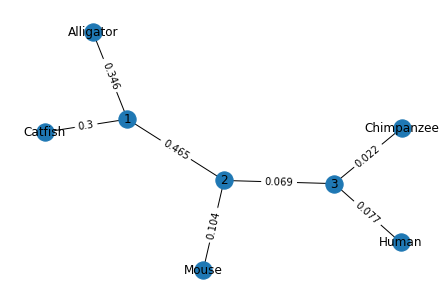

In [32]:
import networkx as nx

renameNodes = {0: 'Human', 1: 'Mouse', 2: 'Chimpanzee', 3: 'Catfish', 4: 'Alligator', 5: '1', 6: '2', 7: '3'}
phylogenetic_tree = nx.Graph()

graph_2 = []

for i, edge in enumerate(graph):
    phylogenetic_tree.add_edge(renameNodes[edge[0]], renameNodes[edge[1]], edge_attr=edge[2])
    graph_2.append((renameNodes[edge[0]], renameNodes[edge[1]], round(edge[2],3)))

graph_df = pd.DataFrame(data=graph_2)
graph_df.columns = ['Node 1', 'Node 2', 'Weight']
#nx.draw(phylogenetic_tree, with_labels = True)

GGG = nx.from_pandas_edgelist(df=graph_df, source='Node 1', target='Node 2', edge_attr='Weight')
pos = nx.spring_layout(GGG)
nx.draw(GGG, pos, with_labels=True)
labels = {e: GGG.edges[e]['Weight'] for e in GGG.edges}
nx.draw_networkx_edge_labels(GGG, pos, edge_labels=labels)

print('Edge List of Tree (Weights Rounded to 3 d.p.):\n')
print(graph_df.to_string(index=False))

print('\n///////////////////////////////////////////////////////////////////\n\nPhylogenetic Tree:')
plt.show()